This is a notebook containing a more in-depth analysis and experimentation on the generation of orthogonal feature spaces.
A more direct implementation can be found in [simulation.py](dataset.py).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
import simplstyles
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

In [30]:
np.random.seed(42)
backend = set_backend("torch_cuda", on_error="warn")
plt.style.use("nord-light-talk")

In [5]:
n_samples_train = 10000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_target = 0.1
hidden_feature_space_names = [r"$\mathbf{A}$", r"$\mathbf{B}$", r"$\mathbf{C}$"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

# Generate features

## Start with random matrix $M$

In [6]:
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M, axis=0)

## SVD

In [7]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)
del M

(10100, 300) (300,) (300, 300)


Text(7.819444444444452, 0.5, 'value')

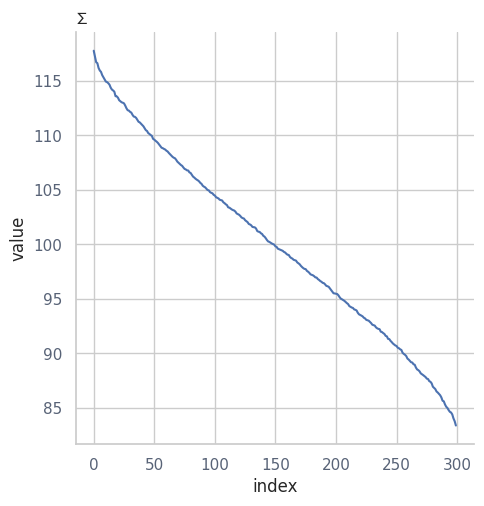

In [8]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

Normalize $\Sigma$

In [9]:
print(np.var(U @ np.diag(S) @ Vt))
S = np.ones_like(S)
print(np.var(U @ np.diag(S) @ Vt))

0.9999999999999993
9.900990099009908e-05


Text(2.6944444444444517, 0.5, 'value')

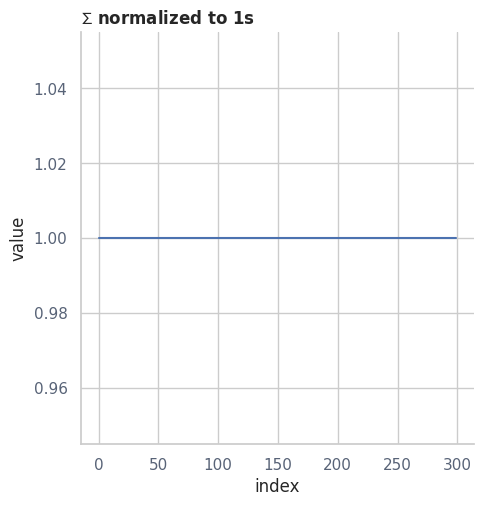

In [10]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ normalized to 1s")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [43]:
feature_spaces = []

start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank

#### make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [44]:
first_transposed_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[j]
        first_transposed_df[
            f"{hidden_feature_space_names[i]}.T x {hidden_feature_space_names[j]}"] = first_transposed.flatten()
        first_transposed = feature_spaces[j].T @ feature_spaces[i]
        first_transposed_df[
            f"{hidden_feature_space_names[j]}.T x {hidden_feature_space_names[i]}"] = first_transposed.flatten()

In [45]:
first_transposed_df.max().max(), first_transposed_df.min().min()

(np.float64(1.5059568175823657e-16), np.float64(-1.702197410802242e-16))

Text(0.5, 18.44444444444445, 'Error')

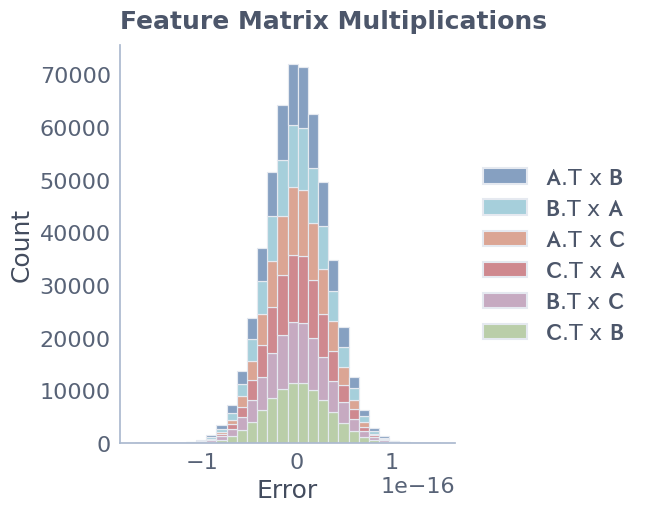

In [46]:
sns.displot(data=first_transposed_df, multiple="stack", bins=30)
plt.title("Feature Matrix Multiplications", y=1.02)
plt.xlabel("Error")

Z-score the feature spaces

In [47]:
for i, feature_space in enumerate(feature_spaces):
    feature_spaces[i] = zscore(feature_space)

# Generate weights

In [48]:
betas = [zscore(np.random.randn(sum(d_list), n_targets)) for _ in d_list]

# create targets

In [49]:
Y = sum([(alpha ** 0.5) * zscore(feature_space @ beta) for alpha, feature_space, beta in
         zip(scalars, feature_spaces, betas)])
Y = zscore(Y)

## add noise

In [50]:
noise = zscore(np.random.randn(n_samples_train + n_samples_test, n_targets), axis=0)
noise *= noise_target ** 0.5
print(noise.var())

0.0999999999999998


In [18]:
Y += noise
print(Y.var())
Y = zscore(Y)

1.1000395554864912


# train simple linear models to confirm feature spaces predict the target

In [19]:
scores = pd.DataFrame()

for feature_space, hidden_name, scalar in zip(feature_spaces, hidden_feature_space_names, scalars):
    model = LinearRegression()
    model.fit(feature_space[:n_samples_train], Y[:n_samples_train])
    score = model.score(feature_space[n_samples_train:], Y[n_samples_train:])
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_name], 'Score': [score],
                      'EV': [scalar]})], ignore_index=True
    )

scores

,feature space,Score,EV
0,$\mathbf{A}$,0.278535,0.333333
1,$\mathbf{B}$,0.279048,0.333333
2,$\mathbf{C}$,0.278889,0.333333


Text(0.0, 1.0, 'Evaluation of Linear Models ')

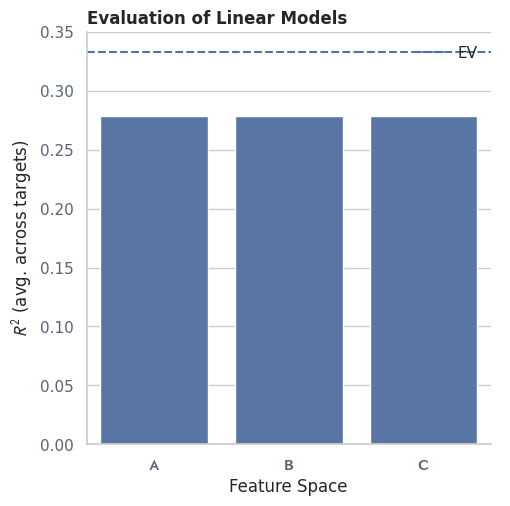

In [20]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", r"$R^2$ (avg. across targets)")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend()
plt.title("Evaluation of Linear Models ")